### step 1 ： 导入常用的函数包

In [1]:
# 常用基础工具 
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time
from tqdm import tqdm 

warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [3]:
#  模型预测使用
from sklearn import linear_model
from sklearn import preprocessing 
from sklearn.svm import SVR 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [5]:
# 数据降维处理
from sklearn.decomposition import PCA, FastICA, FactorAnalysis, SparsePCA

import lightgbm as lgb
import xgboost as xgb

In [6]:
# 参数探索以及 评价的
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error 

In [8]:
# 加上这两行可以一次性输出多个变量而不用print
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', 100)

### step 2:数据读取以及信息查看

In [16]:
train_data = pd.read_csv('data/used_car_train_20200313.csv', sep=' ')
test_data = pd.read_csv('data/used_car_testA_20200313.csv', sep=' ')

print("train_data shape:",  train_data.shape )
print("testA_data shape:", test_data.shape)

train_data shape: (150000, 31)
testA_data shape: (50000, 30)


In [10]:
train_data.info()
# train_data.describe()
# train_data.columns
# train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 31 columns):
SaleID               150000 non-null int64
name                 150000 non-null int64
regDate              150000 non-null int64
model                149999 non-null float64
brand                150000 non-null int64
bodyType             145494 non-null float64
fuelType             141320 non-null float64
gearbox              144019 non-null float64
power                150000 non-null int64
kilometer            150000 non-null float64
notRepairedDamage    150000 non-null object
regionCode           150000 non-null int64
seller               150000 non-null int64
offerType            150000 non-null int64
creatDate            150000 non-null int64
price                150000 non-null int64
v_0                  150000 non-null float64
v_1                  150000 non-null float64
v_2                  150000 non-null float64
v_3                  150000 non-null float64
v_4       

### Step3: 特征与标签构建

In [17]:
#numerical_cols = train_data.select_dtypes(exclude='object').columns
numerical_cols = train_data.select_dtypes(exclude = ['object']).columns
categorical_cols = train_data.select_dtypes(include=['object']).columns
print(numerical_cols)
print(categorical_cols)

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'regionCode', 'seller', 'offerType',
       'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6',
       'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14'],
      dtype='object')
Index(['notRepairedDamage'], dtype='object')


In [18]:
# 选择特征列
feature_cols = [col for col in numerical_cols if col not in ['SaleID','name','regDate','creatDate','price','model','brand','regionCode','seller']]
print(feature_cols)

['bodyType', 'fuelType', 'gearbox', 'power', 'kilometer', 'offerType', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14']


In [19]:
feature_cols = [col for col in feature_cols if 'Type' not in col]
print(feature_cols)

['gearbox', 'power', 'kilometer', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14']


In [20]:
## 提前特征列，标签列构造训练样本和测试样本
X_data = train_data[feature_cols]
Y_data = train_data['price']

X_test = test_data[feature_cols]
print('X train shape:',X_data.shape)
print('X test shape:',X_test.shape)

X train shape: (150000, 18)
X test shape: (50000, 18)


In [22]:
## 定义了一个统计函数，方便后续信息统计
def Sta_inf(data):
    print('_min',np.min(data))
    print('_max:',np.max(data))
    print('_mean',np.mean(data))
    print('_ptp',np.ptp(data))
    print('_std',np.std(data))
    print('_var',np.var(data))

In [23]:
print('Sta of label:')
Sta_inf(Y_data)

Sta of label:
_min 11
_max: 99999
_mean 5923.327333333334
_ptp 99988
_std 7501.973469876635
_var 56279605.942732885


(array([1.23906e+05, 1.89270e+04, 4.91800e+03, 1.34000e+03, 4.71000e+02,
        1.88000e+02, 1.24000e+02, 6.00000e+01, 4.80000e+01, 1.80000e+01]),
 array([1.10000e+01, 1.00098e+04, 2.00086e+04, 3.00074e+04, 4.00062e+04,
        5.00050e+04, 6.00038e+04, 7.00026e+04, 8.00014e+04, 9.00002e+04,
        9.99990e+04]),
 <BarContainer object of 10 artists>)

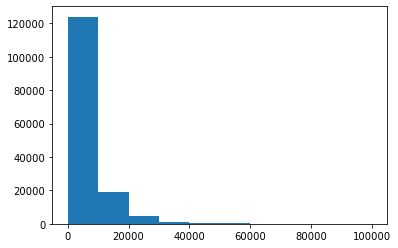

In [25]:
## 绘制标签的统计图，查看标签分布
plt.hist(Y_data)
plt.show()
plt.close()

In [26]:
# 缺省值用 -1 来替代
X_data = X_data.fillna(-1)
X_test = X_test.fillna(-1)


### Step4 特征工程

In [27]:
feature_cols

['gearbox',
 'power',
 'kilometer',
 'v_0',
 'v_1',
 'v_2',
 'v_3',
 'v_4',
 'v_5',
 'v_6',
 'v_7',
 'v_8',
 'v_9',
 'v_10',
 'v_11',
 'v_12',
 'v_13',
 'v_14']

### step4： 模型训练与预测

#### 1) 利用xgb进行五折交叉验证查看模型的参数效果

In [16]:
## xgb-Model
xgr = xgb.XGBRegressor(n_estimators=120, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) #,objective ='reg:squarederror'

scores_train = []
scores = []

sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

for i, (train_idx, val_idx) in enumerate(sk.split(X_data, Y_data)):
    print('--------------------- {} fold ---------------------'.format(i))
    train_x = X_data.iloc[train_idx].values
    train_y = Y_data.iloc[train_idx]
    
    val_x = X_data.iloc[val_idx].values
    val_y = Y_data.iloc[val_idx]
    
    # 开始训练
    xgr.fit(train_x, train_y)
    pred_train = xgr.predict(train_x)
    pred_val = xgr.predict(val_x)
    
    # 指标计算 
    score_train = mean_absolute_error(train_y, pred_train)
    scores_train.append(score_train)
    
    score = mean_absolute_error(val_y, pred_val)
    scores.append(score)
    

print('Train mae:',np.mean(scores_train))
print('Val mae',np.mean(scores))

--------------------- 0 fold ---------------------
[17:37:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--------------------- 1 fold ---------------------
[17:38:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--------------------- 2 fold ---------------------
[17:38:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--------------------- 3 fold ---------------------
[17:39:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--------------------- 4 fold ---------------------
[17:39:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train mae: 623.4622244318589
Val mae 714.2722671070576


In [17]:
score_train

621.8412587378155

In [18]:
scores

[715.8863697415352,
 712.5751479587078,
 701.1871719884396,
 722.801688765812,
 718.9109570807934]

#### 2)定义xgb和lgb模型函数

In [19]:
def build_model_xgb(x_train, y_train):
    model = xgb.XGBRegressor(n_estimators=150, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) #, objective ='reg:squarederror'
    model.fit(x_train, y_train)
    return model 

def build_model_lgb(x_train, y_train):
    estimator = lgb.LGBMRegressor(n_estimators=150, num_leaves=127)
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1, 0.2]
    }
    gbm = GridSearchCV(estimator, param_grid=param_grid)
    gbm.fit(x_train, y_train)
    return gbm 

#### 3)  切分数据集（Train,Val）进行模型训练，评价和预测

In [20]:
x_train,x_val,y_train,y_val = train_test_split(X_data,Y_data,test_size=0.3)


In [21]:
print('Train lgb...')
model_lgb = build_model_lgb(x_train,y_train)
val_lgb = model_lgb.predict(x_val)
MAE_lgb = mean_absolute_error(y_val,val_lgb)
print('MAE of val with lgb:',MAE_lgb)

print('Predict lgb...')
model_lgb_pre = build_model_lgb(X_data,Y_data)
subA_lgb = model_lgb_pre.predict(X_test)
print('Sta of Predict lgb:')
Sta_inf(subA_lgb)

Train lgb...
MAE of val with lgb: 677.2475650679685
Predict lgb...
Sta of Predict lgb:
_min -589.8793550785414
_max: 90760.26063584947
_mean 5906.935218383807
_ptp 91350.13999092802
_std 7344.644970956768
_var 53943809.749400534


In [22]:
print('Train xgb...')
model_xgb = build_model_xgb(x_train,y_train)
val_xgb = model_xgb.predict(x_val)
MAE_xgb = mean_absolute_error(y_val,val_xgb)
print('MAE of val with xgb:',MAE_xgb)

print('Predict xgb...')
model_xgb_pre = build_model_xgb(X_data,Y_data)
subA_xgb = model_xgb_pre.predict(X_test)
print('Sta of Predict xgb:')
Sta_inf(subA_xgb)

Train xgb...
[17:41:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE of val with xgb: 706.3036142241941
Predict xgb...
[17:42:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Sta of Predict xgb:
_min -284.1213
_max: 89791.23
_mean 5903.454
_ptp 90075.35
_std 7321.2134
_var 53600164.0


#### 4) 两模型的结果加权融合

In [23]:
## 这里我们采取了简单的加权融合的方式
val_Weighted = (1-MAE_lgb/(MAE_xgb+MAE_lgb))*val_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*val_xgb
val_Weighted[val_Weighted<0]=10 # 由于我们发现预测的最小值有负数，而真实情况下，price为负是不存在的，由此我们进行对应的后修正
print('MAE of val with Weighted ensemble:',mean_absolute_error(y_val,val_Weighted))

MAE of val with Weighted ensemble: 676.2202159750068


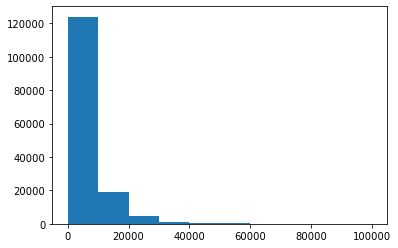

In [24]:
sub_Weighted = (1-MAE_lgb/(MAE_xgb+MAE_lgb))*subA_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*subA_xgb

## 查看预测值的统计进行
plt.hist(Y_data)
plt.show()
plt.close()

#### 5) 输出结果

In [25]:
sub = pd.DataFrame()
sub['SaleID'] = test_data.SaleID
sub['price'] = sub_Weighted
sub.to_csv('./sub_Weighted.csv',index=False)

In [26]:
sub.head()

,SaleID,price
0,200000,1162.259711
1,200001,1763.108628
2,200002,8420.565211
3,200003,1319.787476
4,200004,2156.602090
